### Data Preprocessing

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import Xception, ResNet50V2, VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

### 0~1 float32 Change Function

In [5]:
def get_preprocessed_data(images, labels, scaling = True):
    if scaling:
        images = np.array(images / 255.0, dtype = np.float32)
    else:
        images = np.array(images, dtype = np.float32)
    
    labels = np.array(labels, dtype = np.float32)
    return images, labels

### One Hot Encoding

In [6]:
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    labels = to_categorical(labels)
    return images, labels

### Train, valid, Test Data 

In [8]:
def get_train_valid_test_data(train_images, train_labels, test_images, test_labels):
    train_images, train_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_labels = get_preprocessed_ohe(test_images, test_labels)
    
    train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size = 0.15, random_state = 256)
    return (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels)

### Resize Images

In [9]:
def get_resized_images(images, resize = 64):
    image_net = images.shape[0]
    resized_images = np.zeros((images.shape[0], resize, resize, 3))
    
    for i in range(image_net):
        resized_image = cv2.resize(images[i], (resize, resize))
        resized_images[i] = resized_image
    
    return resized_images

### Create Pretrained Model

In [10]:
def create_model(model_name = 'vgg16', verbose = False):
    input_tensor = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor = input_tensor, include_top = False, weights = 'imagenet')
    elif model_name == 'ResNet50':
        base_model = ResNet50V2(input_tensor = input_tensor, include_top = False, weights = 'imagenet')
    elif model_name == 'Xception':
        base_model = Xception(input_tensor = input_tensor, include_top = False, weights = 'imagenet')
    
    base_model_output = base_model.output
    
    x = GlobalAveragePooling2D()(base_model_output)
    if model_name != 'vgg16':
        x = Dropout(rate = 0.5)(x)
    x = Dense(50, activation = 'relu')(x)
    output = Dense(10, activation = 'softmax')(x)
    
    model = Model(inputs = input_tensor, outputs = output)
    model.summary()
    
    return model

In [11]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

### Train and Evaluation

In [15]:
def do_cifar10_train_evaluation(image_size = IMAGE_SIZE, model_name =  'vgg16'):
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    (train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = get_train_valid_test_data(train_images, train_labels, test_images, test_labels)
    
    print(train_images.shape, train_labels.shape, valid_images.shape, valid_labels.shape, test_images.shape, test_labels.shape)
    
    if image_size > 32:
        train_images = get_resized_images(train_images)
        valid_images = get_resized_images(valid_images)
        test_images = get_resized_images(test_images)
    
    # 학습/검증/테스트 ImageDataGenerator 생성
    train_generator = ImageDataGenerator(
        horizontal_flip = True,
        rescale = 1/255.0
    )
    valid_generator = ImageDataGenerator(rescale = 1/255.0)
    test_generator = ImageDataGenerator(rescale = 1/255.0)
    
    flow_train_gen = train_generator.flow(train_images, train_labels, batch_size=64, shuffle = True)
    flow_valid_gen = valid_generator.flow(valid_images, valid_labels, batch_size=64, shuffle = False)
    flow_test_gen = test_generator.flow(test_images, test_labels, batch_size = 64, shuffle = False)
    
    model = create_model(model_name = model_name)
    model.compile(optimizer = Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    rlr_cb = ReduceLROnPlateau(monitor='val_loss', patience=5, factor = 0.2, mode = 'min', verbose = 1)
    ely_cb = EarlyStopping(monitor = 'val_loss', patience=10, mode = 'min', verbose = 1)
    
    history = model.fit(flow_train_gen, epochs = 40, validation_data = flow_valid_gen, callbacks = [rlr_cb, ely_cb])
    evaluation_result = model.evaluate(flow_test_gen)
    print('테스트 데이터 세트 evaluation 결과 : ', evaluation_result)
    return history , evaluation_result
    

In [17]:
history, evaluation_result = do_cifar10_train_evaluation(image_size=64, model_name = 'Xception')

(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)
83689472/83683744 [==============================] - 7s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 15, 15, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 15, 15, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (No

Epoch 1/40

C:\Users\c\.conda\envs\wongi\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")



665/665 [==============================] - 40s 54ms/step - loss: 0.8602 - accuracy: 0.7189 - val_loss: 1.5420 - val_accuracy: 0.5560
Epoch 2/40
665/665 [==============================] - 35s 53ms/step - loss: 0.4222 - accuracy: 0.8653 - val_loss: 0.8839 - val_accuracy: 0.7069
Epoch 3/40
665/665 [==============================] - 35s 53ms/step - loss: 0.3308 - accuracy: 0.8934 - val_loss: 1.3830 - val_accuracy: 0.6277
Epoch 4/40
665/665 [==============================] - 36s 55ms/step - loss: 0.2769 - accuracy: 0.9093 - val_loss: 0.6759 - val_accuracy: 0.8067
Epoch 5/40
665/665 [==============================] - 36s 54ms/step - loss: 0.2372 - accuracy: 0.9247 - val_loss: 0.5963 - val_accuracy: 0.8253
Epoch 6/40
665/665 [==============================] - 35s 53ms/step - loss: 0.1870 - accuracy: 0.9389 - val_loss: 0.5239 - val_accuracy: 0.8293
Epoch 7/40
665/665 [==============================] - 35s 53ms/step - loss: 0.1963 - accuracy: 0.9369 - val_loss: 0.5817 - val_accuracy: 0.8193
Ep

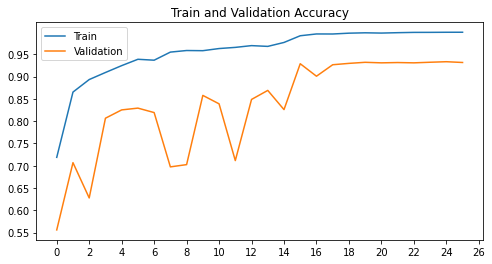

In [22]:
plt.figure(figsize = (8, 4))
plt.yticks(np.arange(0, 1, 0.05))
plt.xticks(np.arange(0, 40, 2))
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.title('Train and Validation Accuracy')
plt.legend()